In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
import matplotlib.pyplot as plt


import monai
from monai.networks.nets import UNETR
from monai.utils import set_determinism,first
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.inferers import SliceInferer
from monai.visualize import matshow3d
from time import sleep

2023-06-21 11:14:53.102061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 11:14:53.482798: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 11:14:55.162334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/opt/sci-soft/software/binutils/2.37-GCCcore-11.2.0/lib:/opt

In [50]:
#Prostate158
path='/nvmescratch/ceib/Prostate/input/prostate158/prostate158_train'
train_df_P158=pd.read_csv(os.path.join(path,'train.csv'))
test_df_P158=pd.read_csv(os.path.join(path,'valid.csv'))

#Picai
data_picai=pd.read_csv('/home/jaalzate/Tartaglia/Prostate_Tartaglia/codes/partition_1.csv')

data_picai["depth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[0])
data_picai["heigth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[1])
data_picai["weigth"] = data_picai['filepath_t2w_cropped'].apply(lambda path_file: nib.load(path_file).shape[2])
data_picai=data_picai[(data_picai['heigth']!=0) & (data_picai['depth']!=0)]
data_picai=data_picai[(data_picai['heigth']>96) & (data_picai['depth']>96)]



data_picai=data_picai[data_picai['filepath_t2w_cropped'].notna()].reset_index()
data_picai_human=data_picai[data_picai['human_labeled']==1]
data_picai.drop(data_picai_human.index, inplace = True)

#data_picai=data_picai[['filepath_t2w_cropped','filepath_adc_cropped','filepath_hbv_cropped','filepath_labelAI_cropped','filepath_seg_zones_cropped','partition']]
#data_picai_human=data_picai_human[['filepath_t2w_cropped','filepath_adc_cropped','filepath_hbv_cropped','filepath_label_cropped','filepath_seg_zones_cropped','partition']]



columns = ['t2', 'adc', 'dwi','t2_anatomy_reader1', 'adc_tumor_reader1']

for df in [train_df_P158, test_df_P158]:
    for column in columns:
        df[column] = df[column].apply(lambda x: os.path.join(path,x))


# test_picai=data_picai[data_picai['partition']=='test']
# test_picai_human=data_picai_human[data_picai_human['partition']=='test']

test_picai=data_picai[(data_picai['partition']=='test') | (data_picai['partition']=='dev')]
test_picai_human=data_picai_human[(data_picai_human['partition']=='test') | (data_picai_human['partition']=='dev')]

test_df = pd.DataFrame({
    't2w': list(test_picai['filepath_t2w_cropped'].values) + list(test_picai_human['filepath_t2w_cropped'].values)+list(test_df_P158['t2'].values),
    'adc': list(test_picai['filepath_adc_cropped'].values) +  list(test_picai_human['filepath_adc_cropped'].values)+list(test_df_P158['adc'].values) ,
    'dwi': list(test_picai['filepath_hbv_cropped'].values) + list(test_picai_human['filepath_hbv_cropped'].values)+list(test_df_P158['dwi'].values),
    'zones': list(test_picai['filepath_seg_zones_cropped'].values) + list(test_picai_human['filepath_seg_zones_cropped'].values)+list(test_df_P158['t2_anatomy_reader1'].values),
    'label': list(test_picai['filepath_labelAI_cropped'].values) + list(test_picai_human['filepath_label_cropped'].values)+list(test_df_P158['adc_tumor_reader1'].values),
    'label_csPCa':list(test_picai['label'].values) + list(test_picai_human['label'].values)+[None]*len(test_df_P158),
    'PIR':list(test_picai['PIRADS'].values) + list(test_picai_human['PIRADS'].values)+[None]*len(test_df_P158)
})



In [51]:
test_df.label_csPCa.value_counts()

0.0    427
1.0    169
Name: label_csPCa, dtype: int64

In [52]:
#test_df=test_df[test_df.label_csPCa==1].reset_index()
test_df=test_df[test_df.PIR==5]

In [53]:
test_df.shape

(8, 7)

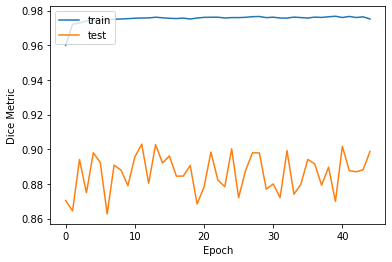

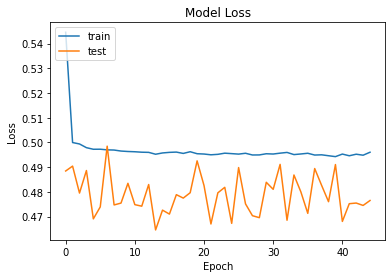

In [54]:
model_dir = '/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/Unetr/128x128'
name='Unetr_128x128'
train_loss = np.load(os.path.join(model_dir, name+'_loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, name+'_metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, name+'_loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, name+'_metric_test.npy'))

plt.figure()
plt.plot(train_metric, label='Dice')
plt.plot(test_metric, label = 'val_Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Metric')
plt.legend(['train', 'test'], loc='upper left')

#plt.savefig('/content/drive/My Drive/Covid19/logs/Figures/'+model_name+'_acc.png')

plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

In [55]:
# Define Transforms

img_columns=["t2","adc","dwi"]
label_column=["label"]

mode=["bilinear","nearest"]

test_files = [{"t2": t2,'adc': adc,'dwi': dwi,"zones":zones, "label": label,'csPCa':PCa,'PIR':pirads} for 
               t2,adc,dwi,zones,label,PCa,pirads in zip(test_df['t2w'].values,
                                 test_df['adc'].values,
                                 test_df['dwi'].values,
                                 test_df['zones'].values,
                                 test_df['label'].values,
                                 test_df['label_csPCa'].values,
                                 test_df['PIR'].values,
                                                       )]
prob=0.175

#Pretransforms
test_transforms = monai.transforms.Compose(
        [
            monai.transforms.LoadImaged(keys=img_columns+label_column+["zones"],image_only=True),
            monai.transforms.AsDiscreted(keys=label_column,threshold=1), #Convert values greater than 1 to 1
            monai.transforms.EnsureChannelFirstd(keys=img_columns+label_column+["zones"]),
            monai.transforms.AsDiscreted(keys="zones",argmax=False,to_onehot=3),
            monai.transforms.LabelToMaskd(keys="zones",select_labels=[1,2]),
            monai.transforms.ResampleToMatchd(keys=["adc","dwi","zones","label"],key_dst="t2",mode=("bilinear","bilinear","nearest","nearest")),#Resample images to t2 dimensions
            monai.transforms.Resized(keys=img_columns+label_column+["zones"],spatial_size=(128,128,-1),mode=("trilinear","trilinear","trilinear","nearest","nearest")),#SAMUNETR: Reshape to have the same dimension
            monai.transforms.ScaleIntensityd(keys=img_columns,minv=0.0, maxv=1.0),
            monai.transforms.NormalizeIntensityd(keys=img_columns),
            monai.transforms.ConcatItemsd(keys=img_columns+["zones"], name='image', dim=0),
            monai.transforms.ConcatItemsd(keys=label_column, name='label', dim=0),  
        ]
)

#PostTransforms

post_transforms_pred_picai = monai.transforms.Compose(
        [
            
            monai.transforms.Invertd(
                keys="pred",  # invert the `pred` data field, also support multiple fields
                transform=test_transforms,
                orig_keys="t2",  # get the previously applied pre_transforms information on the `image` data field,
                # then invert `pred` based on this information. we can use same info
                # for multiple fields, also support different orig_keys for different fields
                nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                # to ensure a smooth output, then execute `AsDiscreted` transform
                #orig_meta_keys="image_meta_dict",
                to_tensor=True,  # convert to PyTorch Tensor after inverting
            ),
            #monai.transforms.Activationsd(keys="pred",sigmoid=True),
            #monai.transforms.AsDiscreted(keys="pred", argmax=True,dim=0),
            #monai.transforms.KeepLargestConnectedComponentd(keys=["pred"],applied_labels=list(range(1, 2))),
            monai.transforms.ToNumpyd(keys="pred"),
            #monai.transforms.SaveImaged(keys="pred", output_dir="./out", output_postfix="seg", resample=False),
        ]
    )


post_transforms_pred = monai.transforms.Compose(
        [
            
            monai.transforms.Invertd(
                keys="pred",  # invert the `pred` data field, also support multiple fields
                transform=test_transforms,
                orig_keys="t2",  # get the previously applied pre_transforms information on the `image` data field,
                # then invert `pred` based on this information. we can use same info
                # for multiple fields, also support different orig_keys for different fields
                nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                # to ensure a smooth output, then execute `AsDiscreted` transform
                #orig_meta_keys="image_meta_dict",
                to_tensor=True,  # convert to PyTorch Tensor after inverting
            ),
            #monai.transforms.Activationsd(keys="pred",sigmoid=True),
            monai.transforms.AsDiscreted(keys="pred",argmax=True,dim=0),
            monai.transforms.KeepLargestConnectedComponentd(keys=["pred"],applied_labels=list(range(1, 2))),
            #monai.transforms.ToNumpyd(keys="pred"),
            #monai.transforms.SaveImaged(keys="pred", output_dir="./out", output_postfix="seg", resample=False),
        ]
    )

post_transforms_label = monai.transforms.Compose(
        [
            monai.transforms.Invertd(keys=["label","t2"],transform=test_transforms,nearest_interp=True, to_tensor=True),
        ]
    )

#test_files = test_files[3::]

In [56]:

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Define model

In [57]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Working on device: {device}')

model = UNETR(
    in_channels=5,
    out_channels=2,
    img_size=(128, 128),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=24,
    pos_embed="conv",
    norm_name="batch",
    res_block=True,
    dropout_rate=0.15,
    spatial_dims=2,
).to(device)
#Load weights
model.load_state_dict(torch.load(
    os.path.join(model_dir, name+"_best_metric_model.pth")))
model.eval()

Working on device: cuda


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv2d(5, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.15, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.15, inplace=False)
          (drop2): Dropout(p=0.15, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3, l=24)
          (out_rearrange): Rearrange('b h l d -> b l (h d)')
          (drop_output):

100%|██████████| 2/2 [00:00<00:00, 29.89it/s]


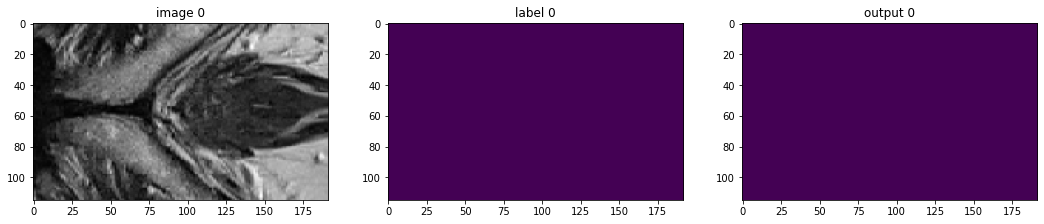

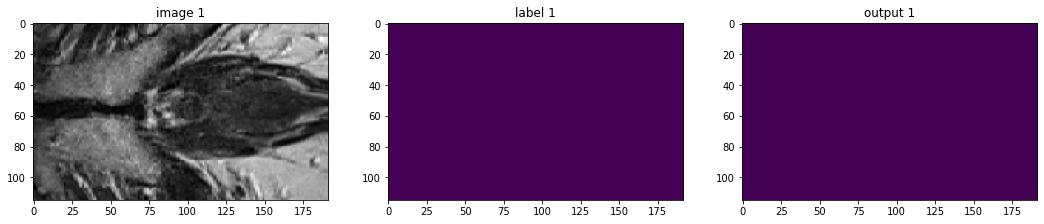

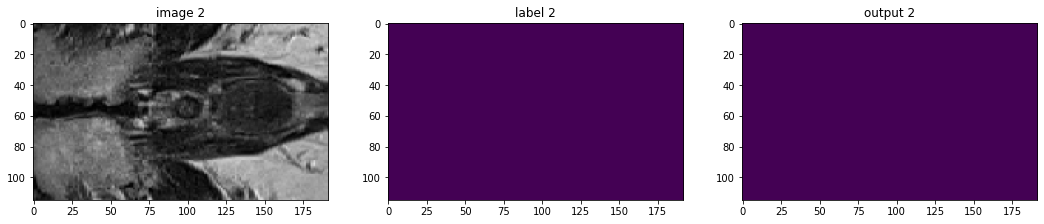

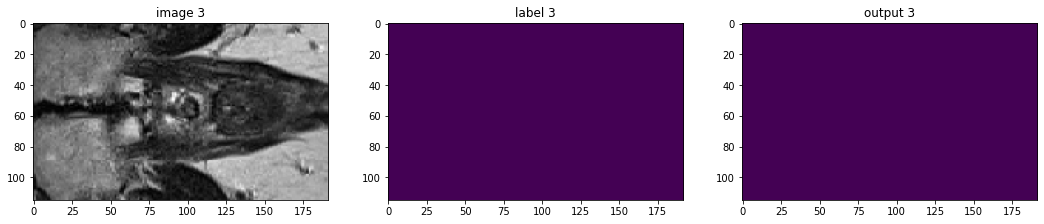

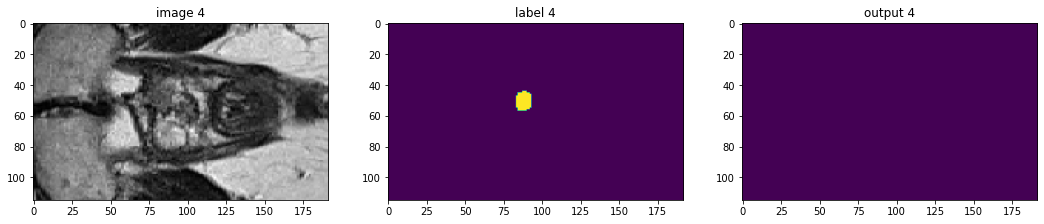

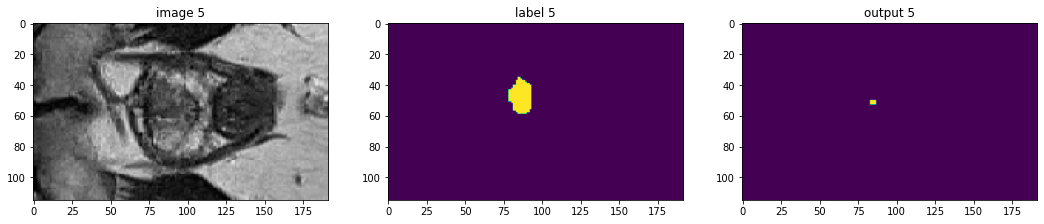

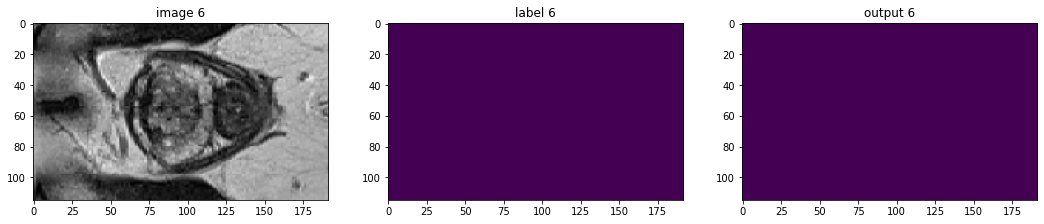

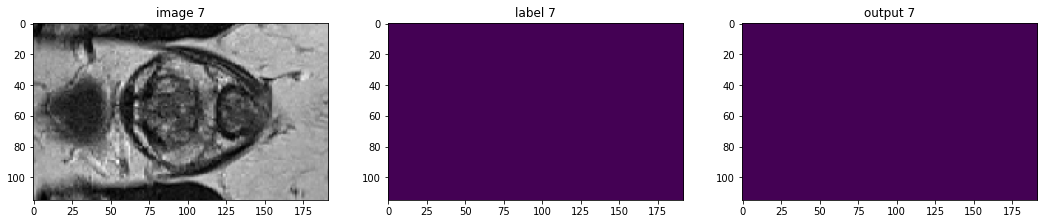

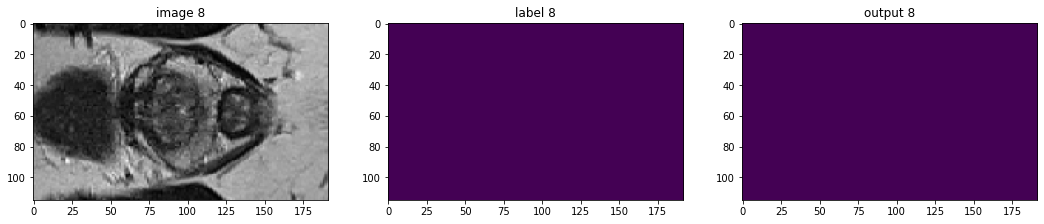

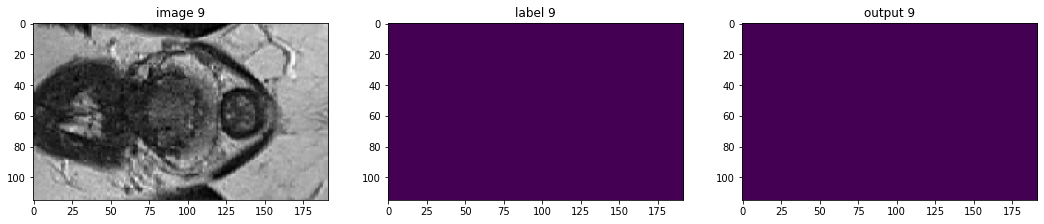

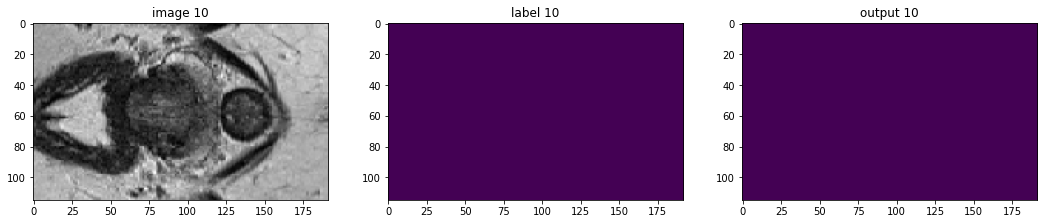

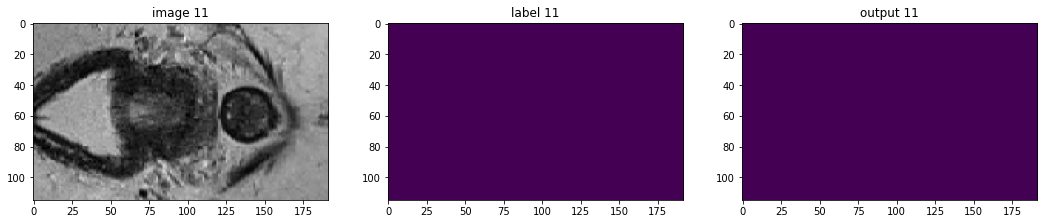

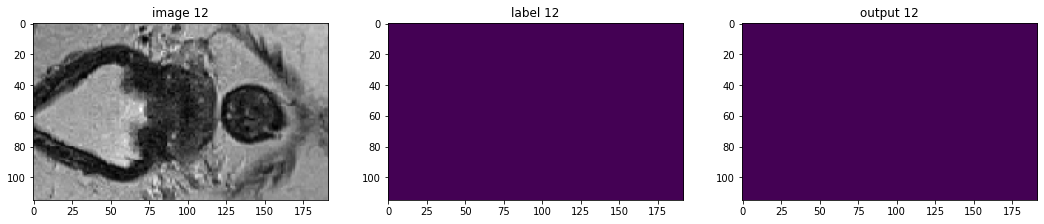

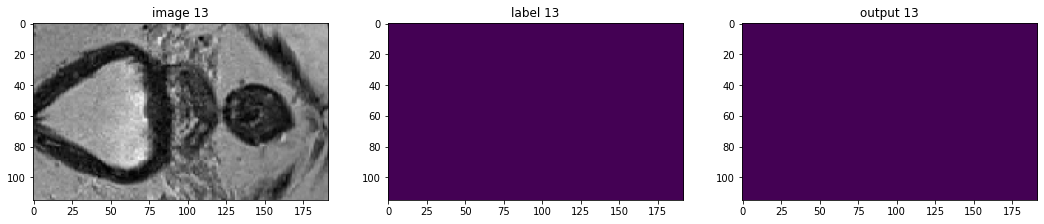

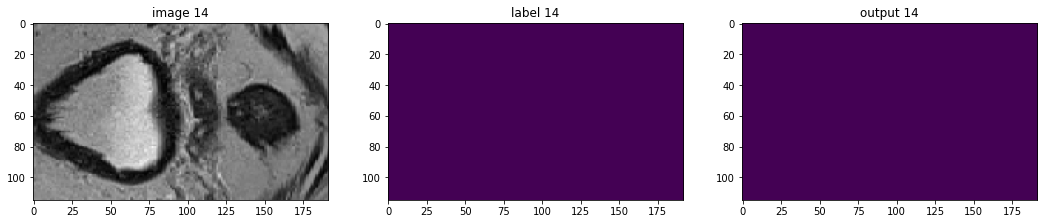

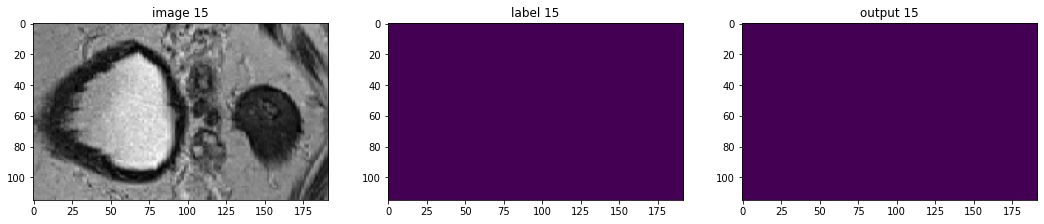

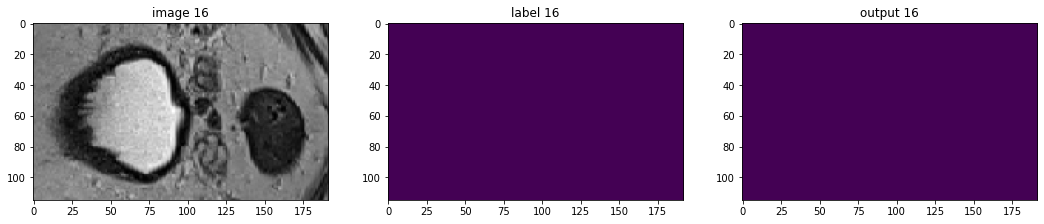

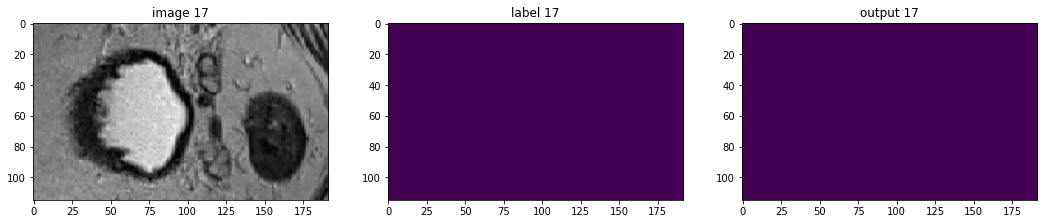

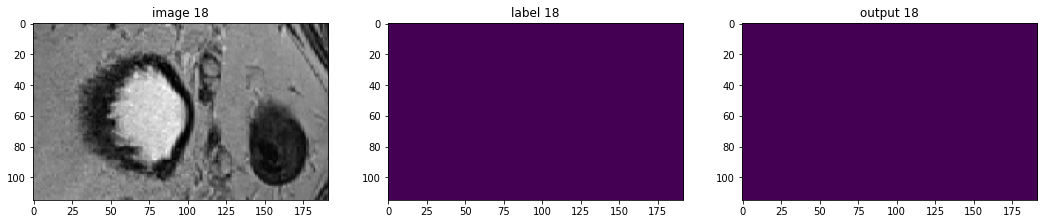

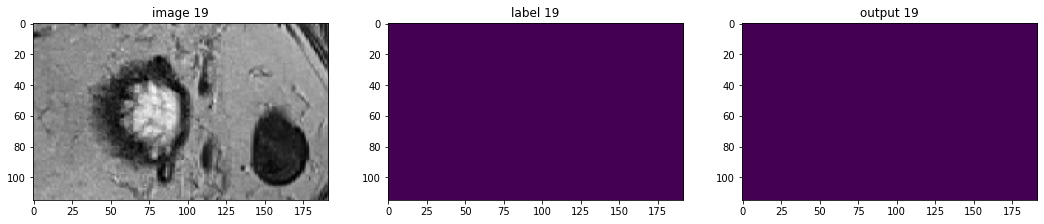

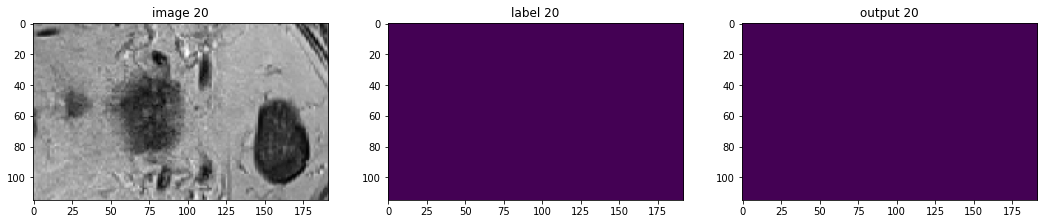

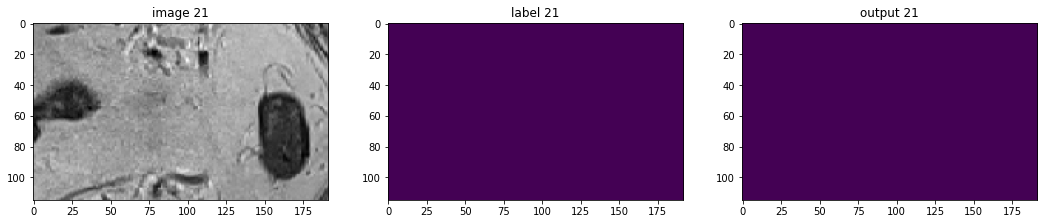

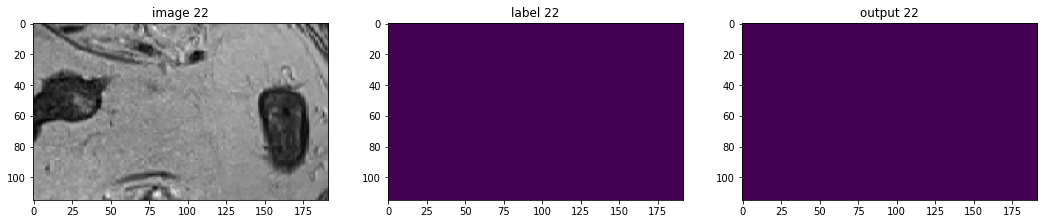

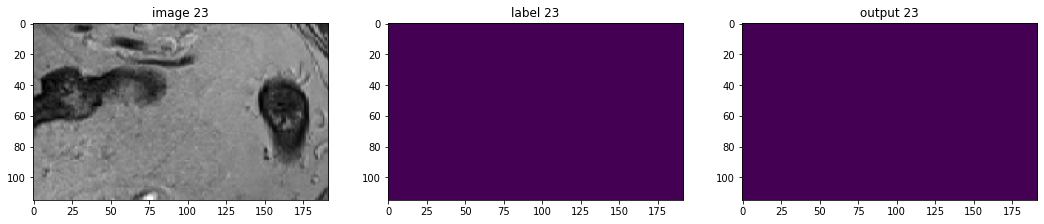

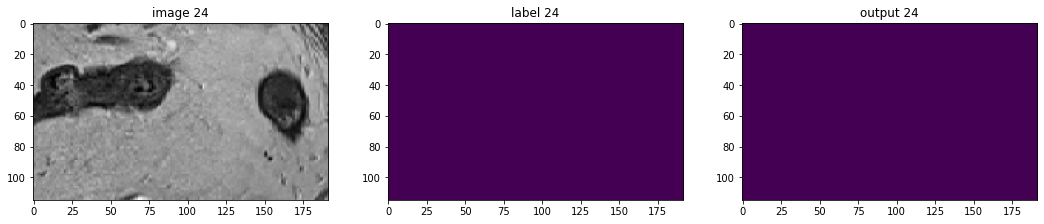

In [58]:
#Predict on one image

with torch.no_grad():
    test_patient = first(test_loader)
    
    test_volume = test_patient["image"]
    test_label = test_patient["label"]

    test_volume, test_label = (test_volume.to(device), test_label.to(device))
    
    inferer=SliceInferer(roi_size=(None, None),sw_batch_size=16,spatial_dim=2,cval=-1,progress=True)
    test_patient["pred"] = inferer(test_volume, model)
    test_outputs=post_transforms_pred(decollate_batch(test_patient))[0]
    test_outputs=post_transforms_label(test_outputs)
    
    for i in range(test_outputs["image"].shape[-1]):
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_outputs["t2"][0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_outputs["label"][0, :, :, i])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs["pred"][0,:, :, i].cpu())
        #plt.colorbar()
        plt.show()
        

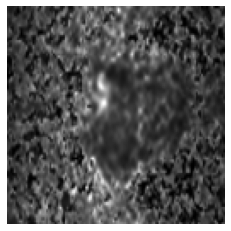

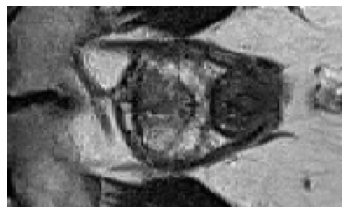

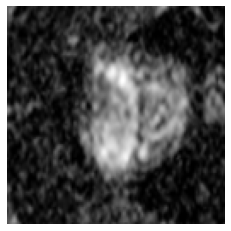

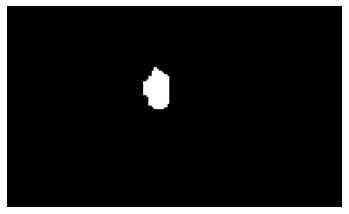

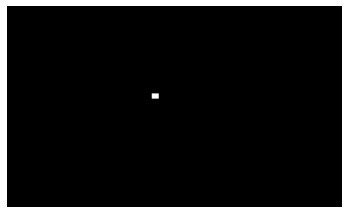

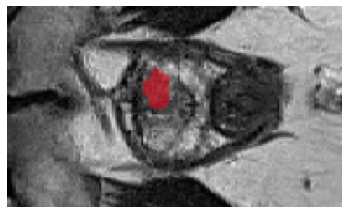

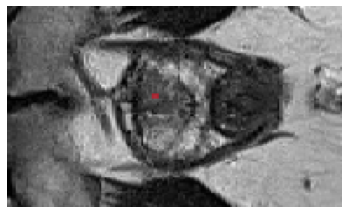

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


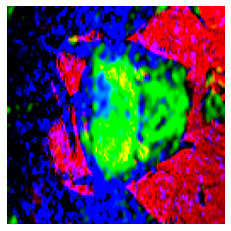

In [59]:
slice_=5
#plt.figure(figsize=(10,10))
#plt.subplot(2,3,1)
plt.imshow(test_outputs['dwi'][0,:,:,slice_],cmap='gray')
plt.axis('off')
plt.show()
#plt.grid()
#plt.subplot(2,3,2)
plt.imshow(test_outputs['t2'][0,:,:,slice_],cmap='gray')
plt.axis('off')
plt.show()
#plt.grid()
#plt.subplot(2,3,3)
plt.imshow(test_outputs['adc'][0,:,:,slice_],cmap='gray')
plt.axis('off')
plt.show()
#plt.subplot(2,3,4)
plt.imshow(test_outputs['label'][0,:,:,slice_],cmap='gray')
plt.axis('off')
plt.show()
#plt.subplot(2,3,5)
plt.imshow(test_outputs['pred'][0,:,:,slice_].cpu(),cmap='gray')
plt.axis('off')
plt.show()
#plt.subplot(2,3,6)

Truth=monai.visualize.utils.blend_images(test_outputs['t2'][:,:,:,slice_],test_outputs['label'][:,:,:,slice_], alpha=0.5, cmap='hsv', rescale_arrays=True, transparent_background=True)
predict=monai.visualize.utils.blend_images(test_outputs['t2'][:,:,:,slice_],test_outputs["pred"][:,:,:,slice_].cpu(), alpha=0.5, cmap='hsv', rescale_arrays=True, transparent_background=True)

plt.imshow(torch.moveaxis(Truth,(0,1,2),(2,0,1)))
plt.axis('off')
plt.show()

plt.imshow(torch.moveaxis(predict,(0,1,2),(2,0,1)))
plt.axis('off')
plt.show()

plt.imshow(torch.moveaxis(test_patient['image'][0,0:3,:,:,slice_],(0,1,2),(2,0,1)),cmap='gray')
plt.axis('off')
plt.show()

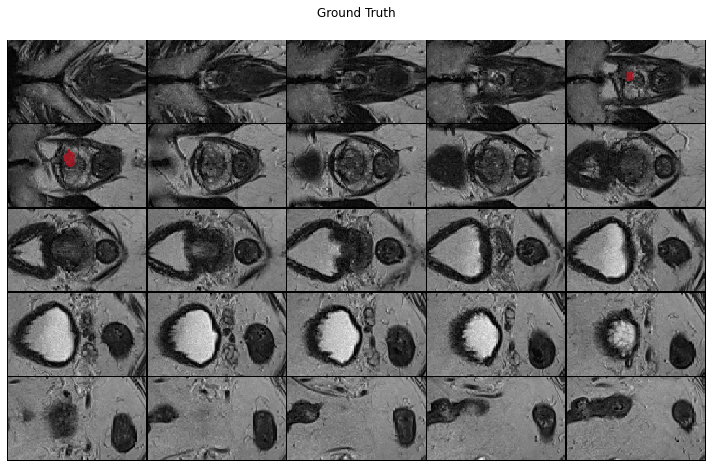

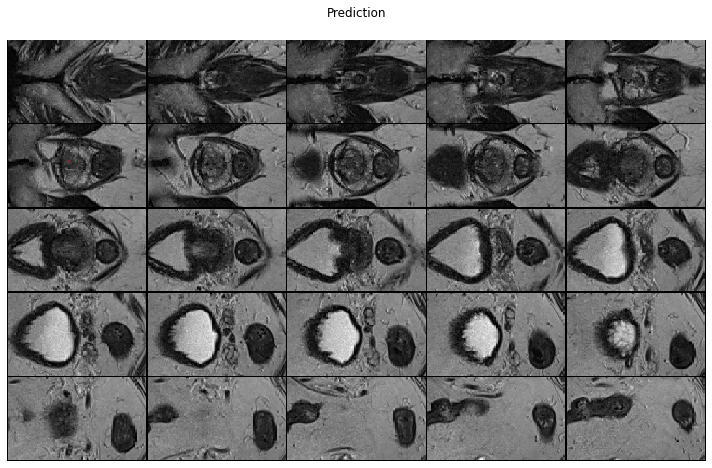

In [60]:
Truth=monai.visualize.utils.blend_images(test_outputs["t2"],test_outputs["label"], alpha=0.5, cmap='hsv', rescale_arrays=True, transparent_background=True)
predict=monai.visualize.utils.blend_images(test_outputs["t2"],test_outputs["pred"].cpu(), alpha=0.5, cmap='hsv', rescale_arrays=True, transparent_background=True)


image=Truth
matshow3d(
    volume=image,
    fig=None, title="Ground Truth",
    figsize=(10, 10),
    every_n=1,
    frame_dim=-1,
    show=True,
    channel_dim=0
)
plt.show()

image=predict
matshow3d(
    volume=image,
    fig=None, title="Prediction",
    figsize=(10, 10),
    every_n=1,
    frame_dim=-1,
    show=True,
    channel_dim=0
)
plt.show()

In [61]:
test_files[0]

{'t2': '/nvmescratch/ceib/Prostate/input/cropped/images/10607_1000621_t2w.nii.gz',
 'adc': '/nvmescratch/ceib/Prostate/input/cropped/images/10607_1000621_adc.nii.gz',
 'dwi': '/nvmescratch/ceib/Prostate/input/cropped/images/10607_1000621_hbv.nii.gz',
 'zones': '/nvmescratch/ceib/Prostate/input/labels/anatomical_delineations/prostate_zones/picai_cropped/10607_1000621_t2w_zones.nii.gz',
 'label': '/nvmescratch/ceib/Prostate/input/cropped/labels/10607_1000621.nii.gz',
 'csPCa': 1.0,
 'PIR': 5.0}

# Evaluation on all images

In [62]:
#Define Metrics
from report_guided_annotation import extract_lesion_candidates
from picai_eval import evaluate


dice_metric = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False,ignore_empty=True)
iou_metric=monai.metrics.MeanIoU(include_background=False,reduction="mean",get_not_nans=False,ignore_empty=True)
HDM_metric=monai.metrics.HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=None, directed=False, reduction="mean", get_not_nans=True)

y_pred=[]
y_true=[]
with torch.no_grad():
    test_epoch_loss = 0
    test_metric = 0
    epoch_metric_test = 0
    test_step = 0
    ap_metric=[]
    for test_data in test_loader:
        test_step += 1
        test_volume, test_label = (test_data["image"].to(device),test_data["label"].to(device))
        inferer=SliceInferer(roi_size=(None, None),sw_batch_size=32,spatial_dim=2,cval=-1,progress=False)
        test_data["pred"] = inferer(test_volume, model)
        test_outputs=post_transforms_pred(decollate_batch(test_data))[0]
        test_outputs=post_transforms_label(test_outputs)
        
        test_outputs_picai=post_transforms_pred_picai(decollate_batch(test_data))[0]
        
        y_true.append(test_outputs['label'])
        y_pred.append(test_outputs_picai['pred'])
        
        dice_metric(y_pred=[test_outputs['pred'].cpu()], y=[test_outputs['label']])
        iou_metric(y_pred=[test_outputs['pred'].cpu()], y=[test_outputs['label']])
#         if len(test_outputs['label'].unique())>1: #Calculate these metrics only in samples with multiple clases
#             HDM_metric(y_pred=test_outputs['pred'].cpu(), y=test_outputs['label'])

In [63]:
len(y_true)

8

In [64]:


#subject_list=['subject-0']
# new_ypred=[]

# for pred in tqdm(y_pred):
#     for p in pred:
#         a=extract_lesion_candidates(p)[0]
#     new_ypred.append(a)
    
new_ytrue=[]
for y in tqdm(y_true):
    new_ytrue.append(y.squeeze())
    
metrics = evaluate(
    y_det=y_pred,
    y_true=new_ytrue,
    y_det_postprocess_func=lambda pred: extract_lesion_candidates(pred[1])[0],
)
# aggregate metrics
AP = metrics.AP
auroc = metrics.auroc
picai_score = metrics.score

# Precision-Recall (PR) curve
precision = metrics.precision
recall = metrics.recall

# Receiver Operating Characteristic (ROC) curve
tpr = metrics.case_TPR
fpr = metrics.case_FPR

# Free-Response Receiver Operating Characteristic (FROC) curve
sensitivity = metrics.lesion_TPR
fp_per_case = metrics.lesion_FPR



print('Average Precision= ',AP)
print('AUCROC= ',auroc)
print('Picai Score= ',picai_score)
print('Dice Score= ', dice_metric.aggregate().item())
print('IoU= ', iou_metric.aggregate().item())


100%|██████████| 8/8 [00:00<00:00, 5245.34it/s]


Average Precision=  0.3
AUCROC=  nan
Picai Score=  nan
Dice Score=  0.3413451910018921
IoU=  0.23999348282814026


No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless


In [50]:
metrics.save_full('/home/jaalzate/Tartaglia/Prostate_Tartaglia/Paper_Resultados/Results/Unetr/metrics_unetr.json')

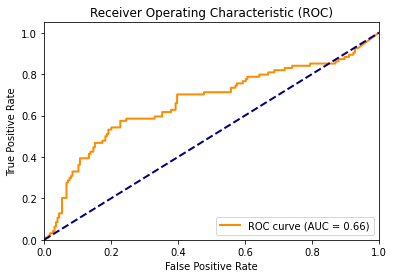

In [40]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr

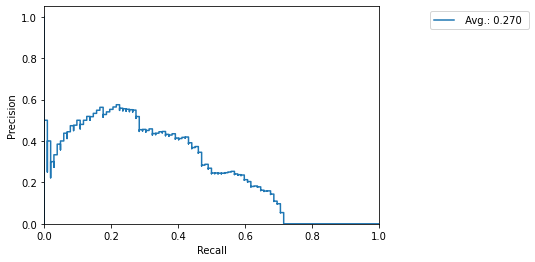

In [41]:
label = " Avg.: %.3f " % AP#plt.figure(1, figsize=(7, 7))
plt.step(recall, precision, where='post', label=label)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
           fancybox=True, ncol=1)
plt.show()

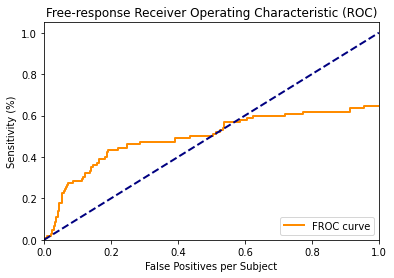

In [42]:
plt.figure()
plt.plot(fp_per_case, sensitivity, color='darkorange', lw=2, label='FROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives per Subject')
plt.ylabel('Sensitivity (%)')
plt.title('Free-response Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()